# ***Libraries Importing***

In [ ]:
!pip install netgraph

In [ ]:
 !pip install cdlib

In [ ]:
!pip install leidenalg

In [ ]:
import csv
import string
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph
from cdlib import algorithms

import igraph as ig
import leidenalg as la
from community import  community_louvain
import networkx.algorithms.community as nx_comm
import time





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install infomap wurlitzer leidenalg

  Using cached infomap-2.7.1.tar.gz (263 kB)
  Preparing metadata (setup.py) ... done
  Using cached wurlitzer-3.1.0-py3-none-any.whl (8.4 kB)


In [ ]:
!pip install bayanpy pyclustering ASLPAw

# ***Preprocessing***

In [ ]:
class Preprocessor:
    @staticmethod
    def preprocess_text(text):
        """
        Preprocesses text data by:
        1. Removing punctuation.
        2. Converting text to lowercase.
        3. Tokenizing text.
        4. Removing stop words.
        5. Lemmatizing tokens.

        Args:
        - text (str): Input text to preprocess.

        Returns:
        - str: Preprocessed text as a string.
        """
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        text = text.lower()
        # Tokenize text
        tokens = word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Perform lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Return preprocessed text as a string
        return ' '.join(lemmatized_tokens)

    @staticmethod
    def read_dblp_dataset(file_path):
        """
        Reads data from the DBLP dataset file and preprocesses it.

        Args:
        - file_path (str): Path to the DBLP dataset file.

        Returns:
        - list: List of dictionaries, each representing a preprocessed paper.
        """
        papers = []
        with open(file_path, 'r', encoding='utf-8') as file:
            paper = None
            references = ""  # Initialize references string
            for line in file:
                line = line.strip()
                if line.startswith("#*"):
                    title = line[2:]
                elif line.startswith("#@"):
                    authors = line[2:].split(',')
                elif line.startswith("#t"):
                    year = int(line[2:])
                elif line.startswith("#c"):
                    venue = line[2:]
                elif line.startswith("#index"):
                    index = int(line[6:])
                elif line.startswith("#%"):
                    references += line[2:] + ','  # Append reference ID to references string
                elif line.startswith("#!"):
                    abstract = line[2:]
                    abstract = Preprocessor.preprocess_text(abstract)  # Preprocess abstract
                    paper = {
                        'title': title,
                        'authors': authors,
                        'year': year,
                        'venue': venue,
                        'index': index,
                        'abstract': abstract,
                        'references': references[:-1]  # Remove trailing comma and store references string
                    }
                    papers.append(paper)
                    paper = None
                    references = ""  # Reset references string
        return papers

    @staticmethod
    def write_csv(papers, file_path):
        """
        Writes preprocessed paper data to a CSV file.

        Args:
        - papers (list): List of dictionaries, each representing a preprocessed paper.
        - file_path (str): Path to the CSV file to write.
        """
        with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['title', 'authors', 'year', 'venue', 'index', 'abstract', 'references']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for paper in papers:
                writer.writerow(paper)


In [ ]:
preprocessor = Preprocessor()
file_path = '/content/drive/MyDrive/DBLP dataset/outputacm.txt'
papers = preprocessor.read_dblp_dataset(file_path)
csv_file_path = '/content/drive/MyDrive/DBLP dataset/dblp_dataset.csv'
preprocessor.write_csv(papers, csv_file_path)

In [ ]:
csv_file_path = '/content/drive/MyDrive/DBLP dataset/dblp_dataset.csv'

In [ ]:
data=pd.read_csv(csv_file_path)

In [ ]:
data.head()

,title,authors,year,venue,index,abstract,references
0,Performance engineering in industry: current p...,"['Ahmed E. Hassan', 'Parminder Flora']",2007,Proceedings of the 6th international workshop ...,2,panel session discus performance engineering p...,NaN
1,"Dude, You Can Do It! How to Build a Sweeet PC","['Darrel Creacy', 'Carlito Vicencio']",2005,NaN,3,whether youre frustrated current pc offering i...,NaN
2,Interpreting Kullback-Leibler divergence with ...,"['Shinto Eguchi', 'John Copas']",2006,Journal of Multivariate Analysis,5,kullbackleibler divergence neymanpearson lemma...,436405
3,TOPP---the OpenMS proteomics pipeline,"['Oliver Kohlbacher', 'Knut Reinert', 'Clemens...",2007,Bioinformatics,7,motivation experimental technique proteomics s...,NaN
4,"Webbots, Spiders, and Screen Scrapers","['Michael Schrenk', 'Michael Shrenk']",2007,NaN,12,internet bigger better mere browser allows web...,NaN


In [ ]:
data['references'].replace('[]', np.NaN, inplace=True)

In [ ]:
data.isnull().sum()

title              0
authors            0
year               0
venue          32024
index              0
abstract          15
references    170080
dtype: int64

In [ ]:
data.shape

(281080, 7)

In [ ]:
data.dropna(subset='venue',inplace=True)

In [ ]:
data.isnull().sum()

title              0
authors            0
year               0
venue              0
index              0
abstract           4
references    138525
dtype: int64

In [ ]:
data['references'].fillna(data['references'].mode()[0], inplace=True)


In [ ]:
data.dropna(subset='abstract',inplace=True)

In [ ]:
data.isnull().sum()

title         0
authors       0
year          0
venue         0
index         0
abstract      0
references    0
dtype: int64

In [ ]:
data.shape

(249052, 7)

In [ ]:
data.columns

Index(['title', 'authors', 'year', 'venue', 'index', 'abstract', 'references'], dtype='object')

In [ ]:
data

,title,authors,year,venue,index,abstract,references
0,Performance engineering in industry: current p...,"['Ahmed E. Hassan', 'Parminder Flora']",2007,Proceedings of the 6th international workshop ...,2,panel session discus performance engineering p...,246511
2,Interpreting Kullback-Leibler divergence with ...,"['Shinto Eguchi', 'John Copas']",2006,Journal of Multivariate Analysis,5,kullbackleibler divergence neymanpearson lemma...,436405
3,TOPP---the OpenMS proteomics pipeline,"['Oliver Kohlbacher', 'Knut Reinert', 'Clemens...",2007,Bioinformatics,7,motivation experimental technique proteomics s...,246511
5,Approximating fluid schedules in crossbar pack...,"['Michael Rosenblum', 'Constantine Caramanis',...",2006,IEEE/ACM Transactions on Networking (TON),17,consider problem motivated desire provide flex...,"357875,214023,317448,319987,334185,95255,29412..."
6,On product covering in 3-tier supply chain mod...,"['Jianer Chen', 'Fenghui Zhang']",2006,Theoretical Computer Science,24,field supply chain management growing rapid pa...,"251778,436906,623227,287885"
...,...,...,...,...,...,...,...
281075,Effectiveness and usability of an online help ...,"['Jérôme Simonin', 'Noëlle Carbonell', 'Daniel...",2008,Proceedings of the 10th international conferen...,629806,empirical study presented aim assessing possib...,"8543,327540,395578,397153,398612"
281076,Busy period analysis of finite QBD processes,"['Chaitanya Garikiparthi', 'Appie van de Liefv...",2008,ACM SIGMETRICS Performance Evaluation Review,629807,present number customer served length busy per...,340965
281077,The Grid as a Single Entity: Towards a Behavio...,"['Jesús Montes', 'Alberto Sánchez', 'Julio J. ...",2008,Proceedings of the OTM 2008 Confederated Inter...,629808,grid emerged last decade large distributed env...,246511
281078,Multimodal system evaluation using modality ef...,"['Manolis Perakakis', 'Alexandros Potamianos']",2008,Proceedings of the 10th international conferen...,629811,paper propose two new objective metric relativ...,"294663,302639,572828"


In [ ]:
df=data.copy().sample(frac=1).reset_index(drop=True)[:2000]

#  ***Network Construction***

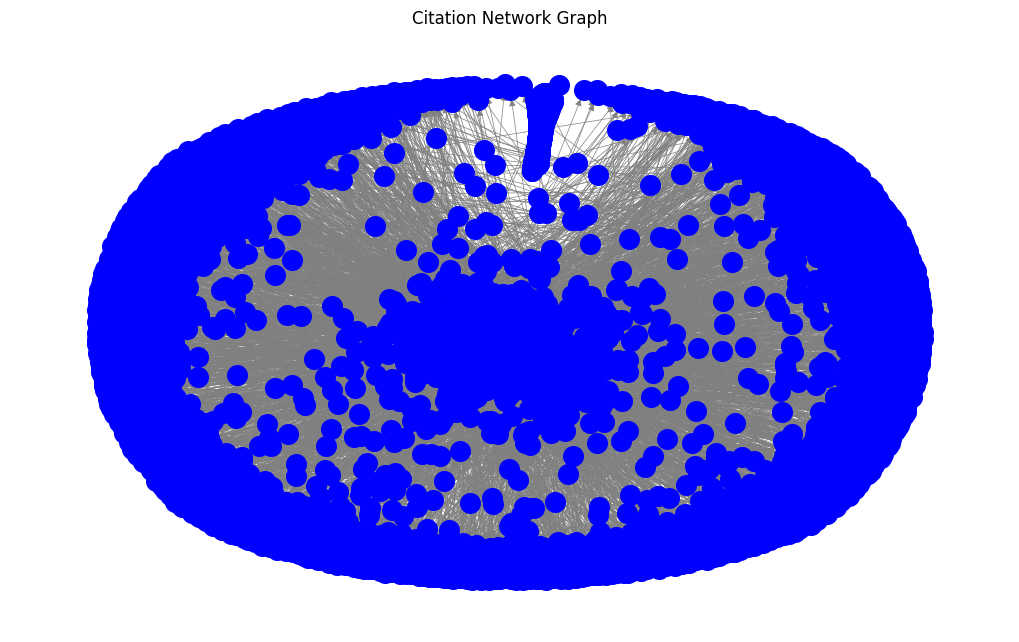

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a directed graph from the dataset
def create_graph(data):
    G = nx.DiGraph()
    for paper in data:
        # Add node with attributes
        G.add_node(paper['index'], title=paper['title'], authors=paper['authors'], year=paper['year'],
                   venue=paper['venue'], abstract=paper['abstract'])
        # Add edges
        references = paper['references']
        if not pd.isna(references):  # Check for NaN values
            for ref in references.split(','):
                G.add_edge(paper['index'], ref.strip())
    return G


data_dict = df.to_dict('records')

# Create the graph
graph = create_graph(data_dict)

# Visualize the graph
plt.figure(figsize=(10, 6))
nx.draw(graph,
        with_labels=False,
        node_size=200,  # Increase node size for better visibility
        node_color='blue',
        font_size=8,
        font_weight='bold',
        width=0.5,  # Adjust edge width
        edge_color='gray',  # Adjust edge color for better contrast
        alpha=1)  # Adjust transparency for better visualization
plt.title('Citation Network Graph')

plt.show()


# ***Community Detection***

In [ ]:


def walktrap_communities(graph):
    start_time = time.time()
    # Convert the networkx graph to an igraph graph
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    reverse_node_mapping = {i: node for node, i in node_mapping.items()}
    edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges()]
    graph_ig = ig.Graph(edges, directed=False)

    # Run the Walktrap algorithm
    walktrap_partition = graph_ig.community_walktrap().as_clustering()

    # Create a dictionary mapping each node to its community index
    community_dict = {}
    for i, community in enumerate(walktrap_partition):
        for node in community:
            community_dict[reverse_node_mapping[node]] = i

    # Optionally, you can return the community partition as a list of lists
    community_partition = [list(map(reverse_node_mapping.get, comm)) for comm in walktrap_partition]

    end_time = time.time()
    execution_time = end_time - start_time

    return community_dict, community_partition, execution_time

def girvan_newman_communities(graph):
    start_time = time.time()
    communities_generator = nx_comm.girvan_newman(graph)
    next_level_communities = next(communities_generator, [])
    partition = {node: i for i, comm in enumerate(next_level_communities) for node in comm}
    end_time = time.time()
    execution_time = end_time - start_time
    return partition, list(next_level_communities), execution_time

def label_propagation_communities(graph):
    start_time = time.time()
    partition = nx_comm.label_propagation.asyn_lpa_communities(graph)
    partition_list = [list(community) for community in partition]
    partition_dict = {node: i for i, comm in enumerate(partition_list) for node in comm}
    end_time = time.time()
    execution_time = end_time - start_time
    return partition_dict, partition_list, execution_time

def louvain_communities(graph):
    start_time = time.time()
    partition = community_louvain.best_partition(graph)
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)
    end_time = time.time()
    execution_time = end_time - start_time
    return partition, list(communities.values()), execution_time

def leiden_communities(graph):
    start_time = time.time()
    # Convert the networkx graph to an igraph graph
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    reverse_node_mapping = {i: node for node, i in node_mapping.items()}
    edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges()]
    graph_ig = ig.Graph(edges, directed=False)

    # Run the Leiden algorithm
    leiden_partition = la.find_partition(graph_ig, la.ModularityVertexPartition)

    # Create a dictionary mapping each node to its community index
    community_dict = {}
    for i, community in enumerate(leiden_partition):
        for node in community:
            community_dict[reverse_node_mapping[node]] = i

    # Optionally, you can return the community partition as a list of lists
    community_partition = [list(map(reverse_node_mapping.get, comm)) for comm in leiden_partition]

    end_time = time.time()
    execution_time = end_time - start_time

    return community_dict, community_partition, execution_time


In [ ]:
def draw_graph(graph, partition, title):
    pos = nx.spring_layout(graph)
    node_color = [partition[node] for node in graph.nodes()]
    nx.draw(graph, pos, node_color=node_color, with_labels=False,
            node_size=200,
            font_size=8,
            font_weight='bold',
            width=0.5,
            edge_color='gray',
            alpha=1, cmap=plt.cm.tab10)
    plt.title(title)
    plt.show()

In [ ]:
def evaluate_communities(graph, partition_list):
    if not partition_list:
        print("No communities detected.")
        return

    # Modularity
    modularity = nx_comm.modularity(graph, partition_list)
    return modularity

In [ ]:
def calculate_silhouette(graph, communities):
    # Create a mapping of node to community ID
    node_to_community = {}
    for community_id, community in enumerate(communities):
        for node in community:
            node_to_community[node] = community_id

    # Compute pairwise distances between nodes and store them in a dictionary
    distances = dict(nx.all_pairs_shortest_path_length(graph))

    silhouette_scores = []
    for node in graph.nodes():
        if node not in node_to_community:
            continue  # Skip nodes that are not part of any community
        community_id = node_to_community[node]
        intra_cluster_distances = []
        inter_cluster_distances = []
        for other_node in graph.nodes():
            if other_node == node:
                continue
            if other_node not in distances[node]:
                continue  # Skip if no path between nodes
            if node_to_community[other_node] == community_id:
                intra_cluster_distances.append(distances[node][other_node])
            else:
                inter_cluster_distances.append(distances[node][other_node])
        a = np.mean(intra_cluster_distances) if intra_cluster_distances else 0
        b = np.mean(inter_cluster_distances) if inter_cluster_distances else 0
        silhouette_score = (b - a) / max(a, b) if max(a, b) != 0 else 0
        silhouette_scores.append(silhouette_score)

    # Compute overall silhouette score
    overall_silhouette_score = np.mean(silhouette_scores)
    return overall_silhouette_score

def label_propagation_partition(graph):
    communities = list(nx.algorithms.community.label_propagation.asyn_lpa_communities(graph))
    return communities

In [ ]:
u_graph = graph.to_undirected()

# Walktrap
walk_trap_com, walk_trap_list, walk_trap_time = walktrap_communities(u_graph)

# Leiden
leiden_com, leiden_list, leiden_time = leiden_communities(u_graph)

# Girvan Newman
gn_com, gn_list, gn_time = girvan_newman_communities(graph)

# Louvain
louvain_com, louvain_list, louvain_time = louvain_communities(u_graph)

# Label Propagation
lp_com, lp_list, lp_time = label_propagation_communities(graph)

# Print the execution times
print("Walktrap Execution Time:", walk_trap_time)
print("Leiden Execution Time:", leiden_time)
print("Girvan Newman Execution Time:", gn_time)
print("Louvain Execution Time:", louvain_time)
print("Label Propagation Execution Time:", lp_time)

Walktrap Execution Time: 1.9831790924072266
Leiden Execution Time: 0.0983424186706543
Girvan Newman Execution Time: 101.36554884910583
Louvain Execution Time: 0.348203182220459
Label Propagation Execution Time: 0.034320831298828125


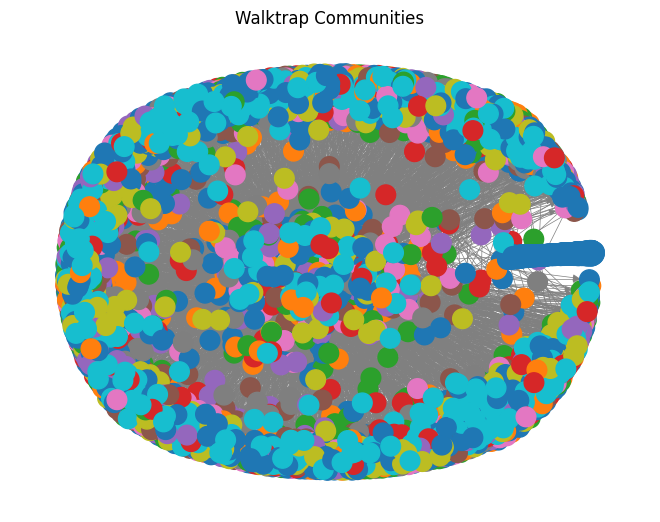

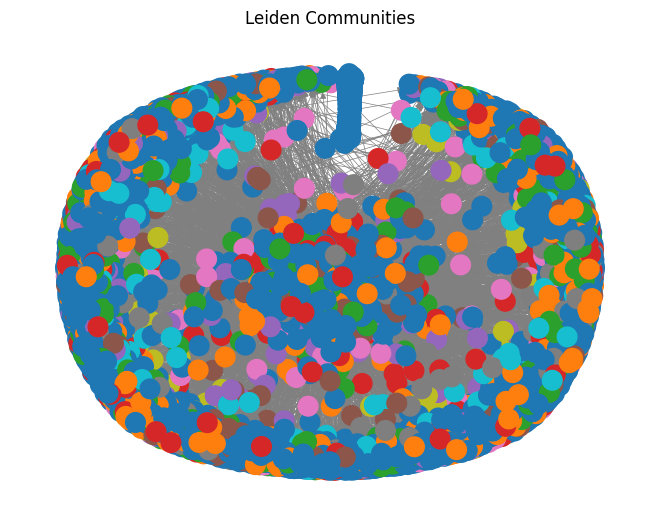

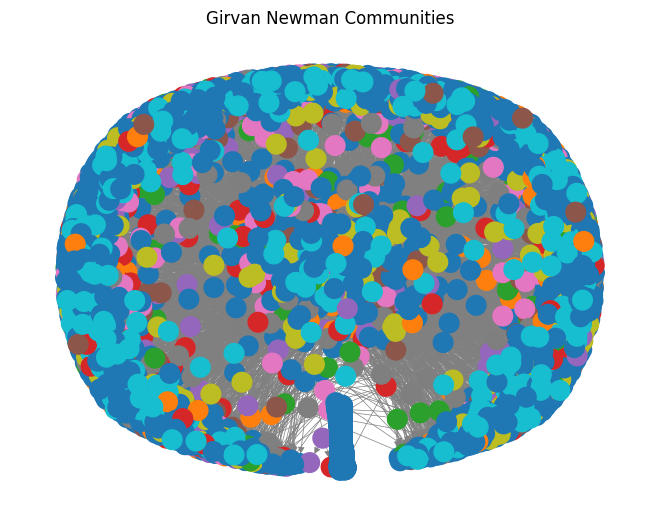

KeyboardInterrupt: 

In [ ]:
# Draw the graph with detected communities for each method
draw_graph(graph, walk_trap_com, "Walktrap Communities")
draw_graph(graph, leiden_com, "Leiden Communities")
draw_graph(graph, gn_com, "Girvan Newman Communities")


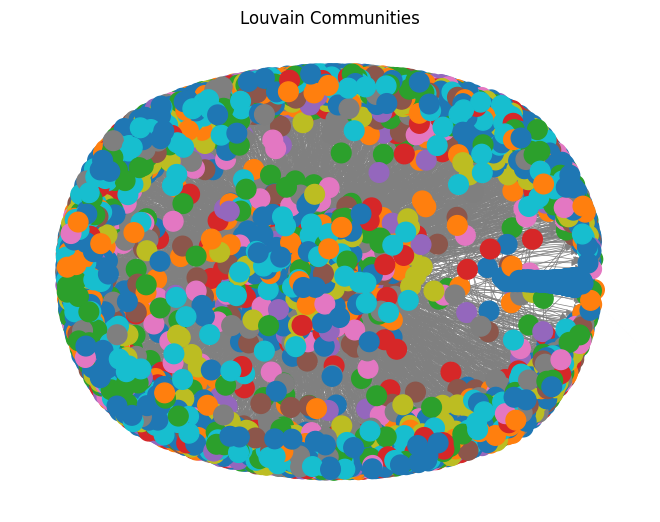

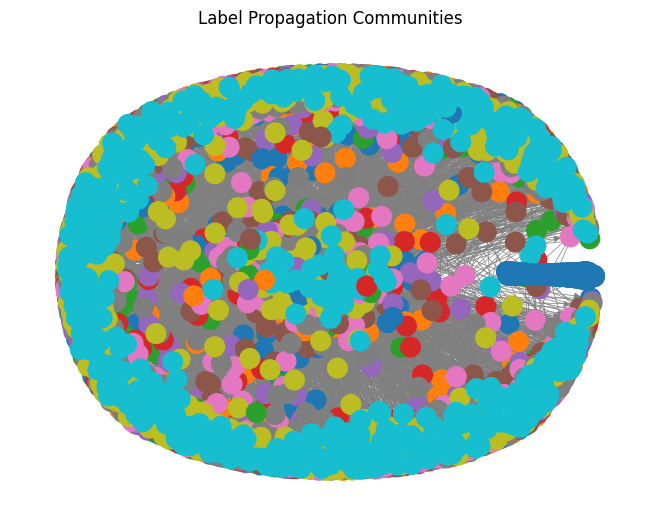

In [72]:
draw_graph(graph, louvain_com, "Louvain Communities")
draw_graph(graph, lp_com, "Label Propagation Communities")

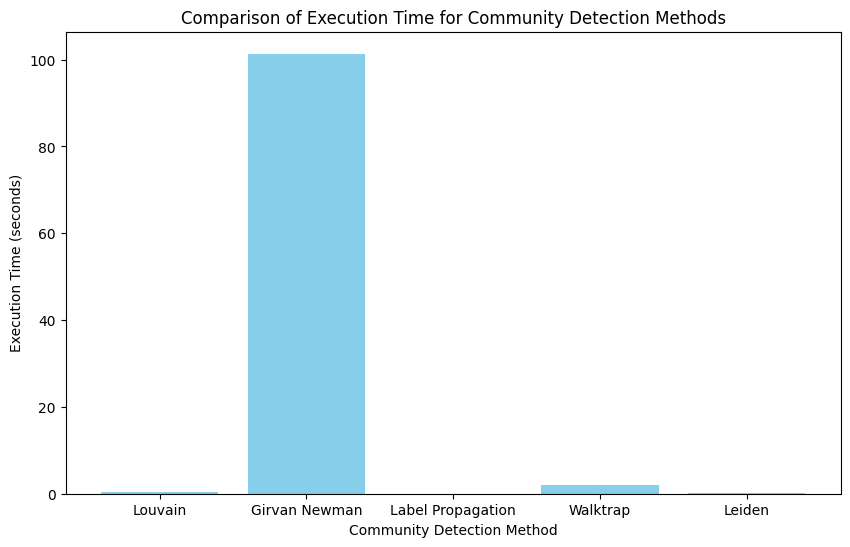

In [ ]:
methods = ['Louvain', 'Girvan Newman', 'Label Propagation', 'Walktrap', 'Leiden']
times = [louvain_time, gn_time, lp_time, walk_trap_time, leiden_time]

plt.figure(figsize=(10, 6))
plt.bar(methods, times, color='skyblue')
plt.xlabel('Community Detection Method')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Time for Community Detection Methods')
plt.show()

In [ ]:
lp_partition = label_propagation_partition(graph)
lp_silhouette = calculate_silhouette(graph, lp_partition)
walk_trap_silhouette=calculate_silhouette(graph,walk_trap_list)
louvain_silhouette = calculate_silhouette(graph, louvain_list)
leiden_silhouette = calculate_silhouette(graph, leiden_list)
gn_silhouette=calculate_silhouette(graph,gn_list)
silhouette_scores = [lp_silhouette,leiden_silhouette,walk_trap_silhouette,louvain_silhouette,gn_silhouette]

In [ ]:
walk_trap_mod=evaluate_communities(graph,walk_trap_list)
louvain_mod=evaluate_communities(graph,louvain_list)
gn_mod=evaluate_communities(graph,gn_list)
leiden_mod=evaluate_communities(graph,leiden_list)
lp_mod=evaluate_communities(graph,lp_list)
modularity_list=[walk_trap_mod,louvain_mod,gn_mod,leiden_mod,lp_mod]
modularity_list = [walk_trap_mod, louvain_mod, gn_mod, leiden_mod, lp_mod]

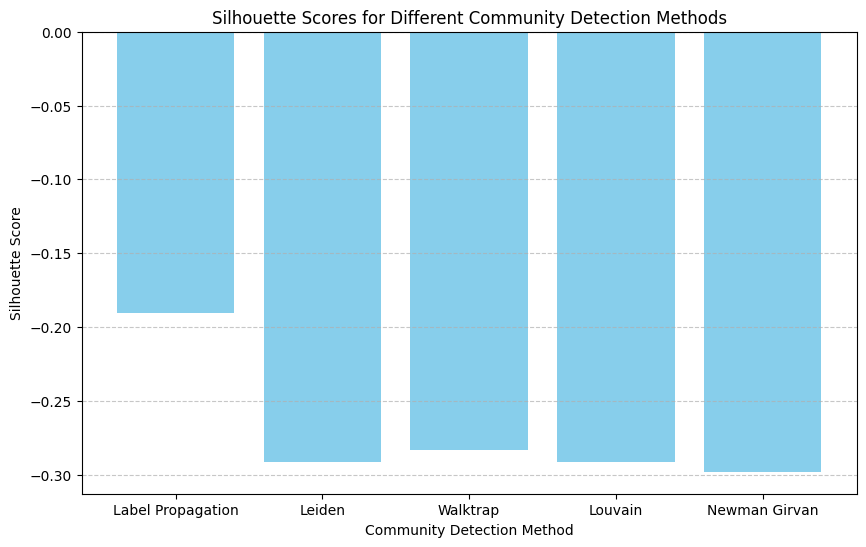

In [ ]:
silhouette_scores = [lp_silhouette, leiden_silhouette, walk_trap_silhouette, louvain_silhouette, gn_silhouette]

# Names of the methods
method_names = ['Label Propagation', 'Leiden', 'Walktrap', 'Louvain', 'Newman Girvan']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(method_names, silhouette_scores, color='skyblue')
plt.xlabel('Community Detection Method')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Community Detection Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

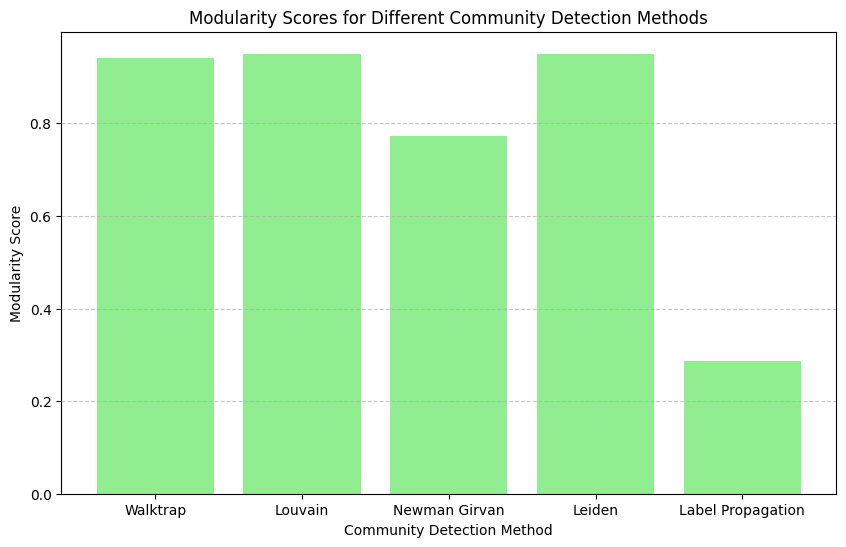

In [ ]:


# Names of the methods
method_names = ['Walktrap', 'Louvain', 'Newman Girvan', 'Leiden', 'Label Propagation']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(method_names, modularity_list, color='lightgreen')
plt.xlabel('Community Detection Method')
plt.ylabel('Modularity Score')
plt.title('Modularity Scores for Different Community Detection Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

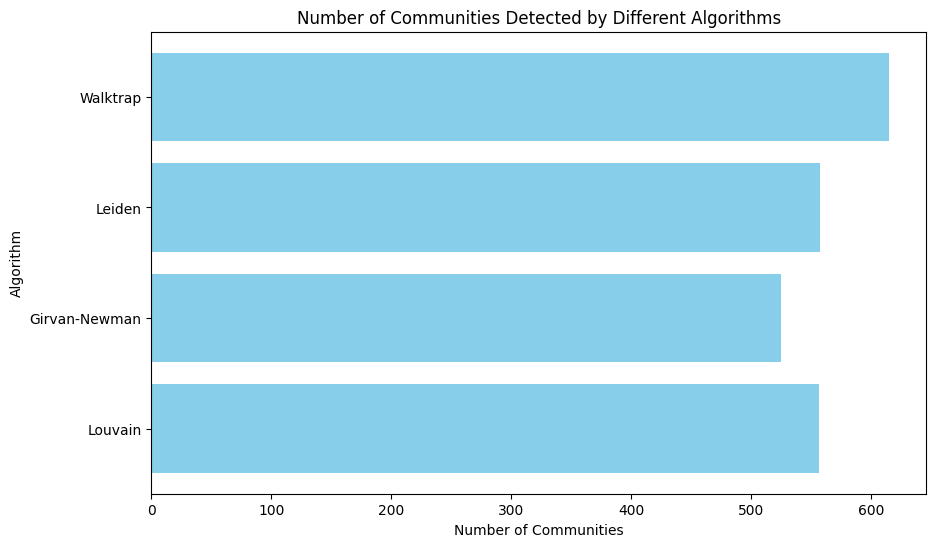

In [ ]:
num_communities = [
    len(walk_trap_list),
    len(leiden_list),
    len(gn_list),
    len(louvain_list)
]

# Define the labels for the algorithms
algorithm_labels = [
    'Walktrap',
    'Leiden',
    'Girvan-Newman',
    'Louvain'

]

# Plot the number of communities detected by each algorithm
plt.figure(figsize=(10, 6))
plt.barh(algorithm_labels, num_communities, color='skyblue')
plt.xlabel('Number of Communities')
plt.ylabel('Algorithm')
plt.title('Number of Communities Detected by Different Algorithms')
plt.gca().invert_yaxis()  # Invert y-axis to display algorithm labels from top to bottom
plt.show()